### 參考網址

https://blog.csdn.net/liequeov/article/details/86742058

### 讀檔及載入套件

In [2]:
# 做完特徵工程前的所有準備 (與前範例相同)

import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

data_path = '/Users/maylin/Documents/Data/'
train_data = pd.read_csv(data_path + 'house_train.csv')
test_data = pd.read_csv(data_path + 'house_test.csv')


In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

### 異常值修改

In [5]:
##測試集1132行,模型報錯,發現異常值,車庫修建年份為2207年,進行修改.
print("修改前的值为: %.1f" % test_data['GarageYrBlt'][1132])
## 推測為2007
test_data.loc[1132,'GarageYrBlt'] = 2007.0
 
print("修改后的值为: %.1f" %test_data['GarageYrBlt'][1132]) 

修改前的值为: 2207.0
修改后的值为: 2007.0


In [6]:
##测试集1089行异常.房子在08年修建,09年装修,但是在07年卖出.这在实际中可能存在,
##但,与数据集中的房子是先修好再卖的不符合,推测房子是在2009年卖出的.
print(test_data['YearBuilt'][1089])
print(test_data['YearRemodAdd'][1089])
print("修改前的值为: %d" % (test_data['YrSold'][1089]))
test_data.loc[1089,'YrSold'] = 2009
print("修改后的值为: %d" % test_data['YrSold'][1089])

2008
2009
修改前的值为: 2007
修改后的值为: 2009


### 删除离群点

In [7]:
# 删除离群点
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
#删除离群点后,使得成果直接提升0.01,非常高.思路应该是根据模型,计算出特征的重要程度,对前几个重要特征进行单个分析来确认是否出现离群点
train_data = train_data.drop(index = [197, 802, 1181, 185, 690])

### 将训练集和测试集联合起来进行特征处理工作

In [8]:
#将训练数据和测试数据联合起来
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.drop(['Id'], axis=1, inplace=True)
#等会对SalePrice单独处理

### 画出各个特征的相关系数矩阵热图，分析各个特征的相关性。
具体可以参考资料的第一项。

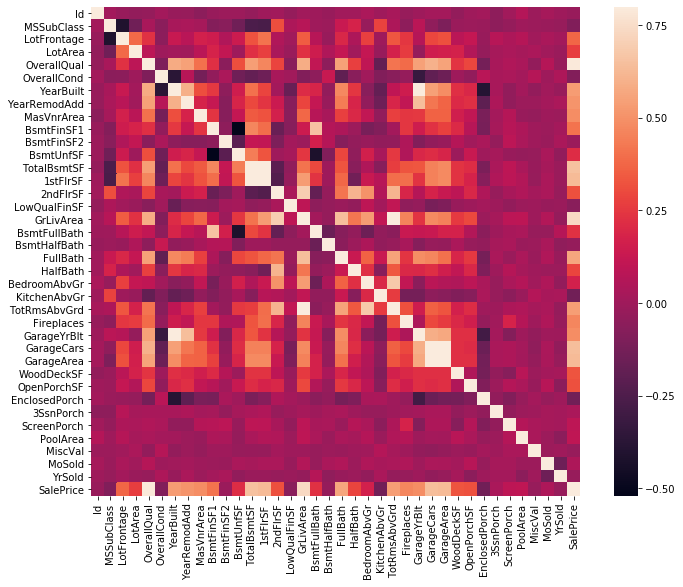

In [9]:
import  matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
 
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

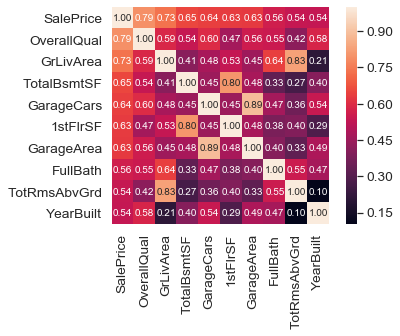

In [10]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 删除重复表达的特征，
比如‘GarageArea’特征和‘GarageCars’特征。车库面积和车库能停多少车是直接相关的。他们表达了相似的信息。同理，可以删除其他3个特征。

In [11]:
#1.删除GarageArea 保留GarageCars
#2.删除TotRmsAbvGrd
#3.删除'GarageYrBlt
#4.删除1stFlrSF
# 两个特征的相关性大于80，只保留其中一个
all_data.drop(['GarageArea'], axis=1, inplace=True)
all_data.drop(['TotRmsAbvGrd'], axis=1, inplace=True)
all_data.drop(['GarageYrBlt'],axis =1, inplace= True)
all_data.drop(['1stFlrSF'], axis=1, inplace=True)

### 删除区分度不高的特征
通过观察发现特征'Utilities'的取值中，取值为‘AllPub’的有2914行，取值为‘NoSeWa’的只有1行。这个特征区分度不够，直接删除。

In [12]:
#查看特征的取值情况
all_data['Utilities'].value_counts()
#删除这个特征
all_data.drop(['Utilities'], axis=1, inplace=True)

### 查看缺失值信息，并根据缺失值比例进行排序

In [13]:
all_data_na = (all_data.isnull().sum(axis = 0) / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
all_data_na

PoolQC          99.725275
MiscFeature     96.394231
Alley           93.200549
Fence           80.460165
FireplaceQu     48.763736
LotFrontage     16.655220
GarageQual       5.460165
GarageFinish     5.460165
GarageCond       5.460165
GarageType       5.391484
BsmtCond         2.815934
BsmtExposure     2.815934
BsmtQual         2.781593
BsmtFinType2     2.747253
BsmtFinType1     2.712912
MasVnrType       0.824176
MasVnrArea       0.789835
MSZoning         0.137363
Functional       0.068681
BsmtFullBath     0.068681
BsmtHalfBath     0.068681
BsmtFinSF2       0.034341
BsmtFinSF1       0.034341
Exterior1st      0.034341
BsmtUnfSF        0.034341
Electrical       0.034341
Exterior2nd      0.034341
SaleType         0.034341
GarageCars       0.034341
KitchenQual      0.034341
TotalBsmtSF      0.034341
dtype: float64

### 填充缺失值

In [14]:
features = all_data
#更换填充方式
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
 
features.loc[2418, 'PoolQC'] = 'Fa'
features.loc[2501, 'PoolQC'] = 'Gd'
features.loc[2597, 'PoolQC'] = 'Fa'
features['PoolQC'] = features['PoolQC'].fillna("None")
features['MiscFeature'] = features['MiscFeature'].fillna("None")

#更换填充方式
features['Alley'] = features['Alley'].fillna("None")
features['Fence'] = features['Fence'].fillna("None")
features['FireplaceQu'] = features['FireplaceQu'].fillna("None")
features.loc[2124, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageCars'] = features['GarageCars'].median()
features.loc[2124, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2574, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2124, 'GarageCond'] = features['GarageCond'].mode()[0]
features.loc[2574, 'GarageCond'] = features['GarageCond'].mode()[0]
features['GarageCond'] = features['GarageCond'].fillna("None")
features['GarageFinish'] = features['GarageFinish'].fillna("None")
features['GarageQual'] = features['GarageQual'].fillna("None")
features['GarageType'] = features['GarageType'].fillna("None")
 
features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
features.loc[947, 'BsmtExposure'] = 'No' 
features.loc[1485, 'BsmtExposure'] = 'No'
features.loc[2038, 'BsmtCond'] = 'TA'
features.loc[2183, 'BsmtCond'] = 'TA'
features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1
 
features['BsmtCond'] = features['BsmtCond'].fillna("None")
features['BsmtExposure'] = features['BsmtExposure'].fillna("None")
features['BsmtFinType1'] = features['BsmtFinType1'].fillna("None")
features['BsmtFinType2'] = features['BsmtFinType2'].fillna("None")
features['BsmtQual'] = features['BsmtQual'].fillna("None")
features['MasVnrType'] = features['MasVnrType'].fillna("None")
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
neighborhood_group = features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics.append(i)        
features.update(features[numerics].fillna(0))
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


### 对‘SalePrice’进行log变换
以使得SalePrice的分布接近正态分布

In [15]:
# 使用log1p函数完成log(1+x)变换
train_y = np.log1p(train_data["SalePrice"])

### 增加一些组合特征
通过原来的特征，构建和价格关系更大的特征

In [16]:
## 增加新的组合特征
 
features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))
 
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])
 
features['HouseYr'] = all_data['YrSold'] - all_data['YearBuilt'] 
features['HouseYrAdd'] = all_data['YrSold'] - all_data['YearRemodAdd'] 
 
#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageCars'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
all_data = features

### 对类别型特征进行LabelCoder。
并不是对所有的类别特征进行LabelCoder，而是他们的取值在顺序上有含义的特征，比如房子的质量等等。

In [17]:
# MSSubClass是房子种类
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
 
# 同样对OverallCond做变换
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
 
# 年与月份
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
 
from sklearn.preprocessing import LabelEncoder
 
cols = ( 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# 使用LabelEncoder做变换
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# 查看維度
print('all_data的数据维度: {}'.format(all_data.shape))
 
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index


all_data的数据维度: (2912, 83)


对数值型特征进行Box-Cox变换以符合使得更加趋近正态

In [18]:
# 对所有数值型的特征都计算skew，计算一下偏度
 
from scipy.stats import boxcox_normmax,skew
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n",skewed_feats)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()
#计算偏度后,不符合正态分布的数据采用box-cox变换
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


Skew in numerical features: 
 MiscVal            21.920854
PoolArea           18.634665
haspool            16.178104
LotArea            13.146898
LowQualFinSF       12.670010
3SsnPorch          11.505634
LandSlope           4.990731
KitchenAbvGr        4.296287
BsmtFinSF2          4.142500
BsmtHalfBath        3.955100
EnclosedPorch       3.952761
ScreenPorch         3.929238
MasVnrArea          2.620321
OpenPorchSF         2.532412
WoodDeckSF          1.844146
Total_porch_sf      1.381373
LotFrontage         1.080294
GrLivArea           1.053589
BsmtFinSF1          0.983105
BsmtUnfSF           0.919408
2ndFlrSF            0.860404
Fireplaces          0.727957
HalfBath            0.697136
TotalBsmtSF         0.672478
BsmtFullBath        0.625679
HouseYr             0.596619
OverallCond         0.563562
Total_Bathrooms     0.488824
HeatingQC           0.483490
HouseYrAdd          0.447009
BedroomAbvGr        0.330147
has2ndfloor         0.291510
OverallQual         0.187620
FullBath    

对剩余的类别型变量进行one-hot编码

In [19]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2912, 234)


进行模型训练前，划分经过特征工程处理后的训练集和测试集

In [20]:
n_train =  len(train_data)
train_x = all_data[:n_train]
test_x = all_data[n_train:]
test_x.shape[0] == test_data.shape[0]
 
print("train_x 的大小为",train_x.shape)
print("train_y 的大小为",train_y.shape)

train_x 的大小为 (1453, 234)
train_y 的大小为 (1453,)


### 模型训练
（导入库并定义相关函数）

In [21]:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel,SelectKBest
import xgboost as xgb
import lightgbm as lgb

In [22]:
# 交叉验证函数
n_folds = 5
 
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)#为了shuffle数据
    rmse= np.sqrt(-cross_val_score(model, train_x_new,train_y.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
 
#cross_val_score函数是指进行交叉验证.在所有度量指标中返回的值,大的值都好于小的值,那么返回的是均方误差的相反数

使用嵌入式方法，进行特征选择

In [23]:
#对数值型特征进行robust_scale
rb_scaler = RobustScaler()
train_x_rob= rb_scaler.fit_transform(train_x)
lasso = Lasso(alpha =0.0005, random_state=1)# 可在此步对模型进行参数设置，这里用默认值。 
lasso.fit(train_x_rob, train_y)	# 训练模型，传入X、y, 数据中不能包含miss_value 
model = SelectFromModel(lasso,prefit=True) 
train_x_new = model.transform(train_x)
test_x_new = model.transform(test_x)

### 模型训练
（查看单个模型在交叉验证中的成绩）

In [24]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                             learning_rate=0.05, n_estimators=720,
                             max_bin = 55, bagging_fraction = 0.8,
                             bagging_freq = 5, feature_fraction = 0.2319,
                             feature_fraction_seed=9, bagging_seed=9,
                             min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [25]:
score = rmsle_cv(lasso)
print("\nLasso 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM 得分: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso 得分: 0.1111 (0.0123)

ElasticNet 得分: 0.1109 (0.0122)

Kernel Ridge 得分: 0.1147 (0.0135)

Gradient Boosting 得分: 0.1166 (0.0121)

Xgboost 得分: 0.1162 (0.0130)

LGBM 得分: 0.1161 (0.0118)



### 对单个模型进行平均集成

In [26]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # 遍历所有模型，你和数据
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]      
        for model in self.models_:
            model.fit(X, y)
 
        return self
    
    # 预估，并对预估结果值做average
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [27]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
 
score = rmsle_cv(averaged_models)
print(" 对基模型集成后的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 对基模型集成后的得分: 0.1076 (0.0130)



### 对模型进行stacking

In [28]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # 遍历拟合原始模型
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # 得到基模型，并用基模型对out_of_fold做预估，为学习stacking的第2层做数据准备
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 学习stacking模型
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 做stacking预估
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [29]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet,GBoost,KRR),meta_model = lasso)
 
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1071 (0.0131)


### 对测试集进行预测

In [30]:
#定義评价函数
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [31]:
#下面模型融合中选择的模型和我的实验结果不符合
test_x = pd.DataFrame(test_x_new)
train_x = pd.DataFrame(train_x_new)

In [32]:
#StackedRegressor:
stacked_averaged_models.fit(train_x.values, train_y.values)
stacked_train_pred = stacked_averaged_models.predict(train_x.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_x.values))
print(rmsle(train_y.values, stacked_train_pred))

0.07701486714693753


In [33]:
#XGBoost:
model_xgb.fit(train_x.values, train_y.values)
xgb_train_pred = model_xgb.predict(train_x.values)
xgb_pred = np.expm1(model_xgb.predict(test_x.values))
print(rmsle(train_y.values, xgb_train_pred))

0.08117508247440623


In [34]:
#LightGBM:
model_lgb.fit(train_x.values, train_y.values)
lgb_train_pred = model_lgb.predict(train_x.values)
lgb_pred = np.expm1(model_lgb.predict(test_x.values))
print(rmsle(train_y.values, lgb_train_pred))

0.0755767869573924


In [35]:
ensemble = stacked_pred*0.6 + xgb_pred*0.15  + lgb_pred*0.25

In [36]:
sub = pd.DataFrame()
sub['Id'] = test_data['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission_10704_2.csv',index=False)